## OfflineTrajectory Optimization

In [21]:
import pinocchio as pin
import crocoddyl
import pinocchio
import numpy as np
urdf_root_path = '/home/Go2py/Go2Py/assets'
urdf_path = '/home/Go2py/Go2Py/assets/urdf/go2_with_arm.urdf'
robot = pin.RobotWrapper.BuildFromURDF(
urdf_path, urdf_root_path, pin.JointModelFreeFlyer())

In [22]:
import sys
import mim_solvers
pinRef        = pin.LOCAL_WORLD_ALIGNED
FRICTION_CSTR = True
MU = 0.8     # friction coefficient

In [23]:
ee_frame_names = ['FL_FOOT', 'FR_FOOT', 'HL_FOOT', 'HR_FOOT', 'Link6']
rmodel = robot.model
rdata = robot.data
# # set contact frame_names and_indices
lfFootId = rmodel.getFrameId(ee_frame_names[0])
rfFootId = rmodel.getFrameId(ee_frame_names[1])
lhFootId = rmodel.getFrameId(ee_frame_names[2])
rhFootId = rmodel.getFrameId(ee_frame_names[3])
efId = rmodel.getFrameId(ee_frame_names[4])

In [24]:
q0 = np.array([0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 1.0] 
               +4*[0.0, 0.77832842, -1.56065452] + 8*[0.0]
                )
x0 =  np.concatenate([q0, np.zeros(rmodel.nv)])

In [ ]:
q0 = np.array([0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 1.0] 
               +4*[0.0, 0.77832842, -1.56065452] + 8*[0.0]
                )
x0 =  np.concatenate([q0, np.zeros(rmodel.nv)])

pinocchio.forwardKinematics(rmodel, rdata, q0)
pinocchio.updateFramePlacements(rmodel, rdata)
rfFootPos0 = rdata.oMf[rfFootId].translation
rhFootPos0 = rdata.oMf[rhFootId].translation
lfFootPos0 = rdata.oMf[lfFootId].translation
lhFootPos0 = rdata.oMf[lhFootId].translation 
efPos0 = rdata.oMf[efId].translation

In [ ]:
comRef = (rfFootPos0 + rhFootPos0 + lfFootPos0 + lhFootPos0) / 4
comRef[2] = pinocchio.centerOfMass(rmodel, rdata, q0)[2].item() 
print(f'The desired CoM position is: {comRef}')

In [7]:
supportFeetIds = [lfFootId, rfFootId, lhFootId, rhFootId]
supportFeePos = [lfFootPos0, rfFootPos0, lhFootPos0, rhFootPos0]

In [8]:
state = crocoddyl.StateMultibody(rmodel)
actuation = crocoddyl.ActuationModelFloatingBase(state)
nu = actuation.nu

In [9]:
comDes = []

N_ocp = 250 #100
dt = 0.02
T = N_ocp * dt
radius = 0.065
for t in range(N_ocp+1):
    comDes_t = comRef.copy()
    w = (2 * np.pi) * 0.2 # / T
    comDes_t[0] += radius * np.sin(w * t * dt) 
    comDes_t[1] += radius * (np.cos(w * t * dt) - 1)
    comDes += [comDes_t]

In [10]:
import friction_utils
running_models = []
constraintModels = []

for t in range(N_ocp+1):
    contactModel = crocoddyl.ContactModelMultiple(state, nu)
    costModel = crocoddyl.CostModelSum(state, nu)

    # Add contact
    for frame_idx in supportFeetIds:
        support_contact = crocoddyl.ContactModel3D(state, frame_idx, np.array([0., 0., 0.]), pinRef, nu, np.array([0., 0.]))
        # print("contact name = ", rmodel.frames[frame_idx].name + "_contact")
        contactModel.addContact(rmodel.frames[frame_idx].name + "_contact", support_contact) 

    # Add state/control reg costs

    state_reg_weight, control_reg_weight = 1e-1, 1e-3

    freeFlyerQWeight = [0.]*3 + [500.]*3
    freeFlyerVWeight = [10.]*6
    legsQWeight = [0.01]*(rmodel.nv - 6)
    legsWWeights = [1.]*(rmodel.nv - 6)
    stateWeights = np.array(freeFlyerQWeight + legsQWeight + freeFlyerVWeight + legsWWeights)    


    stateResidual = crocoddyl.ResidualModelState(state, x0, nu)
    stateActivation = crocoddyl.ActivationModelWeightedQuad(stateWeights**2)
    stateReg = crocoddyl.CostModelResidual(state, stateActivation, stateResidual)

    if t == N_ocp:
        costModel.addCost("stateReg", stateReg, state_reg_weight*dt)
    else:
        costModel.addCost("stateReg", stateReg, state_reg_weight)

    if t != N_ocp:
        ctrlResidual = crocoddyl.ResidualModelControl(state, nu)
        ctrlReg = crocoddyl.CostModelResidual(state, ctrlResidual)
        costModel.addCost("ctrlReg", ctrlReg, control_reg_weight)      


    # Add COM task
    com_residual = crocoddyl.ResidualModelCoMPosition(state, comDes[t], nu)
    com_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
    com_track = crocoddyl.CostModelResidual(state, com_activation, com_residual) # What does it correspond to exactly?
    if t == N_ocp:
        costModel.addCost("comTrack", com_track, 1e5)
    else:
        costModel.addCost("comTrack", com_track, 1e5)

    # End Effecor Position Task
    ef_residual = crocoddyl.ResidualModelFrameTranslation(state, efId, efPos0, nu)
    ef_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
    ef_track = crocoddyl.CostModelResidual(state, ef_activation, ef_residual)
    if t == N_ocp:
        costModel.addCost("efTrack", ef_track, 1e5)
    else:
        costModel.addCost("efTrack", ef_track, 1e5)
        

    constraintModelManager = crocoddyl.ConstraintModelManager(state, actuation.nu)
    if(FRICTION_CSTR):
        if(t != N_ocp):
            for frame_idx in supportFeetIds:
                name = rmodel.frames[frame_idx].name + "_contact"
                residualFriction = friction_utils.ResidualFrictionCone(state, name, MU, actuation.nu)
                constraintFriction = crocoddyl.ConstraintModelResidual(state, residualFriction, np.array([0.]), np.array([np.inf]))
                constraintModelManager.addConstraint(name + "friction", constraintFriction)

    dmodel = crocoddyl.DifferentialActionModelContactFwdDynamics(state, actuation, contactModel, costModel, constraintModelManager, 0., True)
    model = crocoddyl.IntegratedActionModelEuler(dmodel, dt)

    running_models += [model]


In [11]:
# Create shooting problem
ocp = crocoddyl.ShootingProblem(x0, running_models[:-1], running_models[-1])

solver = mim_solvers.SolverCSQP(ocp)
solver.max_qp_iters = 1000
max_iter = 500
solver.with_callbacks = True
solver.use_filter_line_search = False
solver.termination_tolerance = 1e-4
solver.eps_abs = 1e-6
solver.eps_rel = 1e-6

In [ ]:
xs = [x0]*(solver.problem.T + 1)
us = solver.problem.quasiStatic([x0]*solver.problem.T) 
solver.solve(xs, us, max_iter)   

In [77]:
nq, nv, N = rmodel.nq, rmodel.nv, len(xs) 
jointPos_sol = []
jointVel_sol = []
jointAcc_sol = []
jointTorques_sol = []
centroidal_sol = []
xs, us = solver.xs, solver.us
x = []
for time_idx in range (N):
    q, v = xs[time_idx][:nq], xs[time_idx][nq:]
    pin.framesForwardKinematics(rmodel, rdata, q)
    pin.computeCentroidalMomentum(rmodel, rdata, q, v)
    centroidal_sol += [
        np.concatenate(
            [pin.centerOfMass(rmodel, rdata, q, v), np.array(rdata.hg.linear), np.array(rdata.hg.angular)]
            )
            ]
    jointPos_sol += [q]
    jointVel_sol += [v]
    x += [xs[time_idx]]
    if time_idx < N-1:
        jointAcc_sol +=  [solver.problem.runningDatas[time_idx].xnext[nq::]] 
        jointTorques_sol += [us[time_idx]]




sol = {'x':x, 'centroidal':centroidal_sol, 'jointPos':jointPos_sol, 
                    'jointVel':jointVel_sol, 'jointAcc':jointAcc_sol, 
                    'jointTorques':jointTorques_sol}       

for frame_idx in supportFeetIds:
    # print('extract foot id ', frame_idx, "_name = ", rmodel.frames[frame_idx].name)
    ct_frame_name = rmodel.frames[frame_idx].name + "_contact"
    datas = [solver.problem.runningDatas[i].differential.multibody.contacts.contacts[ct_frame_name] for i in range(N-1)]
    ee_forces = [datas[k].f.vector for k in range(N-1)] 
    sol[ct_frame_name] = [ee_forces[i] for i in range(N-1)]     
    

In [ ]:
import matplotlib.pyplot as plt
constrained_sol = sol
time_lin = np.linspace(0, T, solver.problem.T)
fig, axs = plt.subplots(4, 3, constrained_layout=True)
for i, frame_idx in enumerate(supportFeetIds):
    ct_frame_name = rmodel.frames[frame_idx].name + "_contact"
    forces = np.array(constrained_sol[ct_frame_name])
    axs[i, 0].plot(time_lin, forces[:, 0], label="Fx")
    axs[i, 1].plot(time_lin, forces[:, 1], label="Fy")
    axs[i, 2].plot(time_lin, forces[:, 2], label="Fz")
    # Add friction cone constraints 
    Fz_lb = (1./MU)*np.sqrt(forces[:, 0]**2 + forces[:, 1]**2)
    # Fz_ub = np.zeros(time_lin.shape)
    # axs[i, 2].plot(time_lin, Fz_ub, 'k-.', label='ub')
    axs[i, 2].plot(time_lin, Fz_lb, 'k-.', label='lb')
    axs[i, 0].grid()
    axs[i, 1].grid()
    axs[i, 2].grid()
    axs[i, 0].set_ylabel(ct_frame_name)
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 2].legend()

axs[3, 0].set_xlabel(r"$F_x$")
axs[3, 1].set_xlabel(r"$F_y$")
axs[3, 2].set_xlabel(r"$F_z$")
fig.suptitle('Force', fontsize=16)


comDes = np.array(comDes)
centroidal_sol = np.array(constrained_sol['centroidal'])
plt.figure()
plt.plot(comDes[:, 0], comDes[:, 1], "--", label="reference")
plt.plot(centroidal_sol[:, 0], centroidal_sol[:, 1], label="solution")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("COM trajectory")
plt.show()

In [ ]:
mujoco_joint_names = \
['FL_hip_joint',
 'FL_thigh_joint',
 'FL_calf_joint',
 'FR_hip_joint',
 'FR_thigh_joint',
 'FR_calf_joint',
 'RL_hip_joint',
 'RL_thigh_joint',
 'RL_calf_joint',
 'RR_hip_joint',
 'RR_thigh_joint',
 'RR_calf_joint',
 'Joint1',
 'Joint2',
 'Joint3',
 'Joint4',
 'Joint5',
 'Joint6',
 'Joint7_1',
 'Joint7_2']

for joint_name in mujoco_joint_names:
    joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, joint_name)
    print(f'Joint {joint_name} has id {joint_id}')


In [ ]:
pinocchio_joint_names = \
['FL_HAA_joint',
 'FL_HFE_joint',
 'FL_KFE_joint',
    'FR_HAA_joint',
    'FR_HFE_joint',
    'FR_KFE_joint',
    'HL_HAA_joint',
    'HL_HFE_joint',
    'HL_KFE_joint',
    'HR_HAA_joint',
    'HR_HFE_joint',
    'HR_KFE_joint',
    'Joint1',
    'Joint2',
    'Joint3',
    'Joint4',
    'Joint5',
    'Joint6',
    'Joint7_1',
    'Joint7_2']


for joint_name in pinocchio_joint_names:
    joint_id = rmodel.getJointId(joint_name)
    print(f'Joint {joint_name} has id {joint_id}')


In [116]:
pin_idx_to_mujoco_idx = []
for i in range(len(pinocchio_joint_names)):
    joint_name = pinocchio_joint_names[i]
    pin_joint_id = rmodel.getJointId(joint_name)
    mujoco_joint_name = mujoco_joint_names[i]
    mujoco_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, mujoco_joint_name)
    pin_idx_to_mujoco_idx.append(mujoco_joint_id)

pin_idx_to_mujoco_idx = np.array(pin_idx_to_mujoco_idx) - min(pin_idx_to_mujoco_idx)

In [ ]:
import mujoco
model = mujoco.MjModel.from_xml_path('/home/Go2py/Go2Py/assets/mujoco/go2_with_arm.xml')
data = mujoco.MjData(model)
viewer = mujoco.viewer.launch_passive(model, data)

In [118]:
import time
for k in range(1000):
    i = k % len(xs)
    q0 = xs[i][:27]
    qx = q0[3]
    qy = q0[4]
    qz = q0[5]
    qw = q0[6]
    q0[3:7] = [qw, qx, qy, qz]
    q0[7:] = q0[7:][pin_idx_to_mujoco_idx]
    data.qpos[:] = q0

    mujoco.mj_step(model, data)
    viewer.sync()
    time.sleep(1/60)

## Online MPC

In [1]:
import os
import sys
import mim_solvers
import friction_utils
import mujoco
import pinocchio as pin
import crocoddyl
import pinocchio
import numpy as np
import mujoco.viewer

class Go2MPC:
    def __init__(self, assets_path, HORIZON=250, friction_mu = 0.2, dt = 0.02):
        self.assets_path = assets_path
        self.HORIZON = HORIZON
        self.max_iterations = 500
        self.dt = dt
        self.urdf_path = os.path.join(assets_path, 'urdf/go2_with_arm.urdf')
        self.xml_path = os.path.join(assets_path, 'mujoco/go2_with_arm.xml')
        self.pin_robot = pin.RobotWrapper.BuildFromURDF(self.urdf_path, self.assets_path, pin.JointModelFreeFlyer())
        self.pinRef = pin.LOCAL_WORLD_ALIGNED
        self.friction_mu = friction_mu 
        self.rmodel = self.pin_robot.model
        self.rdata = self.pin_robot.data

        self.mpc_to_unitree_name_map = \
        {'FL_HAA_joint':'FL_hip_joint',
         'FL_HFE_joint':'FL_thigh_joint',
         'FL_KFE_joint':'FL_calf_joint',
         'FR_HAA_joint':'FR_hip_joint',
         'FR_HFE_joint':'FR_thigh_joint',
         'FR_KFE_joint':'FR_calf_joint',
         'HL_HAA_joint':'RL_hip_joint',
         'HL_HFE_joint':'RL_thigh_joint',
         'HL_KFE_joint':'RL_calf_joint',
         'HR_HAA_joint':'RR_hip_joint',
         'HR_HFE_joint': 'RR_thigh_joint',
         'HR_KFE_joint': 'RR_calf_joint',
         'Joint1':'Joint1',
         'Joint2':'Joint2',
         'Joint3':'Joint3',
         'Joint4':'Joint4',
         'Joint5':'Joint5',
         'Joint6':'Joint6'
         }
        self.unitree_to_mpc_name_map = {val:key for key, val in self.mpc_to_unitree_name_map.items()}
        self.unitree_joint_order = ['FR', 'FL', 'RR', 'RL']

        mpc_to_unitree_idx_map = {}
        unitree_id = 0
        for foot_name in self.unitree_joint_order:
            for actuator in ['_hip_joint', '_thigh_joint', '_calf_joint']:
                unitree_actuator_name = foot_name+actuator
                mpc_joint_name = self.unitree_to_mpc_name_map[unitree_actuator_name]
                mpc_joint_id = self.rmodel.getJointId(mpc_joint_name)
                mpc_to_unitree_idx_map[mpc_joint_id-2]=unitree_id
                unitree_id+=1

        for unitree_actuator_name in ['Joint1', 'Joint2', 'Joint3', 'Joint4', 'Joint5', 'Joint6']:
                mpc_joint_name = self.unitree_to_mpc_name_map[unitree_actuator_name]
                mpc_joint_id = self.rmodel.getJointId(mpc_joint_name)
                mpc_to_unitree_idx_map[mpc_joint_id-2]=unitree_id
                unitree_id+=1

        self.mpc_to_unitree_idx = np.zeros(18).astype(np.int32)    # mpc_state[mpc_to_unitree_idx] -> state/command in unitree order 
        self.unitree_to_mpc_idx = np.zeros(18).astype(np.int32)        # unitree_state[unitree_to_mpc] -> state/command in mpc order
        for mpc_idx, unitree_idx in mpc_to_unitree_idx_map.items():
            self.mpc_to_unitree_idx[mpc_idx] = unitree_idx
            self.unitree_to_mpc_idx[unitree_idx] = mpc_idx

        # set contact frame_names and_indices
        ee_frame_names = ['FL_FOOT', 'FR_FOOT', 'HL_FOOT', 'HR_FOOT', 'ef_tip']
        self.lfFootId = self.rmodel.getFrameId(ee_frame_names[0])
        self.rfFootId = self.rmodel.getFrameId(ee_frame_names[1])
        self.lhFootId = self.rmodel.getFrameId(ee_frame_names[2])
        self.rhFootId = self.rmodel.getFrameId(ee_frame_names[3])
        self.armEEId = self.rmodel.getFrameId(ee_frame_names[4])
        self.running_models = []
        self.constraintModels = []
        
        self.ccdyl_state = crocoddyl.StateMultibody(self.rmodel)
        self.ccdyl_actuation = crocoddyl.ActuationModelFloatingBase(self.ccdyl_state)
        self.nu = self.ccdyl_actuation.nu

    def initialize(self, q0=np.array([0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 1.0] 
                    +4*[0.0, 0.77832842, -1.56065452] + 6*[0.0]
                        )):
        self.q0 = q0.copy()
        self.x0 =  np.concatenate([q0, np.zeros(self.rmodel.nv)])
        pinocchio.forwardKinematics(self.rmodel, self.rdata, q0)
        pinocchio.updateFramePlacements(self.rmodel, self.rdata)
        self.rfFootPos0 = self.rdata.oMf[self.rfFootId].translation
        self.rhFootPos0 = self.rdata.oMf[self.rhFootId].translation
        self.lfFootPos0 = self.rdata.oMf[self.lfFootId].translation
        self.lhFootPos0 = self.rdata.oMf[self.lhFootId].translation 
        self.armEEPos0 = self.rdata.oMf[self.armEEId].translation
        self.armEEOri0 = self.rdata.oMf[self.armEEId].rotation
        self.supportFeetIds = [self.lfFootId, self.rfFootId, self.lhFootId, self.rhFootId]
        # self.supportFeePos = [self.lfFootPos0, self.rfFootPos0, self.lhFootPos0, self.rhFootPos0]
        self.xs = [self.x0]*(self.HORIZON + 1)
        self.createProblem()
        self.createSolver()
        self.us = self.solver.problem.quasiStatic([self.x0]*self.HORIZON) 

    def createProblem(self):
        #First compute the desired state of the robot
        comRef = (self.rfFootPos0 + self.rhFootPos0 + self.lfFootPos0 + self.lhFootPos0) / 4
        comRef[2] = pinocchio.centerOfMass(self.rmodel, self.rdata, self.q0)[2].item() 
        eeDes = self.armEEPos0
        comDes = []
        dt = self.dt
        # radius = 0.065
        radius = 0.0
        for t in range(self.HORIZON+1):
            comDes_t = comRef.copy()
            w = (2 * np.pi) * 0.2 # / T
            comDes_t[0] += radius * np.sin(w * t * dt) 
            comDes_t[1] += radius * (np.cos(w * t * dt) - 1)
            comDes += [comDes_t]
        body_com_ref = comDes
        arm_eff_ref = [eeDes]*(self.HORIZON+1)
        # Now define the model
        for t in range(self.HORIZON+1):
            self.contactModel = crocoddyl.ContactModelMultiple(self.ccdyl_state, self.nu)
            costModel = crocoddyl.CostModelSum(self.ccdyl_state, self.nu)

            # Add contacts
            for frame_idx in self.supportFeetIds:
                support_contact = crocoddyl.ContactModel3D(self.ccdyl_state, frame_idx, np.array([0., 0., 0.]), self.pinRef, self.nu, np.array([0., 0.]))
                self.contactModel.addContact(self.rmodel.frames[frame_idx].name + "_contact", support_contact) 

            # Contact for the EE
            support_contact = crocoddyl.ContactModel3D(self.ccdyl_state, self.armEEId, np.array([0., 0., 0.]), pin.LOCAL, self.nu, np.array([0., 0.]))
            self.contactModel.addContact(self.rmodel.frames[self.armEEId].name + "_contact", support_contact) 
            # Add state/control regularization costs
            state_reg_weight, control_reg_weight = 1e-1, 1e-3

            freeFlyerQWeight = [0.]*3 + [500.]*3
            freeFlyerVWeight = [10.]*6
            legsQWeight = [0.01]*(self.rmodel.nv - 6)
            legsWWeights = [1.]*(self.rmodel.nv - 6)
            stateWeights = np.array(freeFlyerQWeight + legsQWeight + freeFlyerVWeight + legsWWeights)    
            stateResidual = crocoddyl.ResidualModelState(self.ccdyl_state, self.x0, self.nu)

            stateActivation = crocoddyl.ActivationModelWeightedQuad(stateWeights**2)
            stateReg = crocoddyl.CostModelResidual(self.ccdyl_state, stateActivation, stateResidual)

            if t == self.HORIZON:
                costModel.addCost("stateReg", stateReg, state_reg_weight*self.dt)
            else:
                costModel.addCost("stateReg", stateReg, state_reg_weight)

            if t != self.HORIZON:
                ctrlResidual = crocoddyl.ResidualModelControl(self.ccdyl_state, self.nu)
                ctrlReg = crocoddyl.CostModelResidual(self.ccdyl_state, ctrlResidual)
                costModel.addCost("ctrlReg", ctrlReg, control_reg_weight)      


            # Body COM Tracking Cost
            com_residual = crocoddyl.ResidualModelCoMPosition(self.ccdyl_state, body_com_ref[t], self.nu)
            com_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
            com_track = crocoddyl.CostModelResidual(self.ccdyl_state, com_activation, com_residual) # What does it correspond to exactly?
            if t == self.HORIZON:
                # costModel.addCost("comTrack", com_track, 1e5)
                costModel.addCost("comTrack", com_track, 1e5)
            else:
                costModel.addCost("comTrack", com_track, 1e1)

            # End Effecor Position Tracking Cost
            ef_residual = crocoddyl.ResidualModelFrameTranslation(self.ccdyl_state, self.armEEId, arm_eff_ref[t], self.nu) # Check this cost term            
            ef_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
            ef_track = crocoddyl.CostModelResidual(self.ccdyl_state, ef_activation, ef_residual)

            ef_rotation_residual = crocoddyl.ResidualModelFrameRotation(self.ccdyl_state, self.armEEId, self.armEEOri0, self.nu)
            ef_rot_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
            ef_rot_track = crocoddyl.CostModelResidual(self.ccdyl_state, ef_rot_activation, ef_rotation_residual)


            if t == self.HORIZON:
                costModel.addCost("efTrack", ef_track, 1e5)
                costModel.addCost("efRotTrack", ef_rot_track, 1e5)
            else:
                costModel.addCost("efTrack", ef_track, 1e1)
                # costModel.addCost("efTrack", ef_track, 0.0)
                costModel.addCost("efRotTrack", ef_rot_track, 1e1)
                
                
                
            # Friction Cone Constraints
            constraintModelManager = crocoddyl.ConstraintModelManager(self.ccdyl_state, self.ccdyl_actuation.nu)
            if(t != self.HORIZON):
                for frame_idx in self.supportFeetIds:
                    name = self.rmodel.frames[frame_idx].name + "_contact"
                    residualFriction = friction_utils.ResidualFrictionCone(self.ccdyl_state, name, self.friction_mu, self.ccdyl_actuation.nu)
                    constraintFriction = crocoddyl.ConstraintModelResidual(self.ccdyl_state, residualFriction, np.array([0.]), np.array([np.inf]))
                    constraintModelManager.addConstraint(name + "friction", constraintFriction)

            dmodel = crocoddyl.DifferentialActionModelContactFwdDynamics(self.ccdyl_state, self.ccdyl_actuation, self.contactModel, costModel, constraintModelManager, 0., True)
            model = crocoddyl.IntegratedActionModelEuler(dmodel, self.dt)
            self.running_models += [model]
        self.ocp = crocoddyl.ShootingProblem(self.x0, self.running_models[:-1], self.running_models[-1])
        
    def createSolver(self):
        solver = mim_solvers.SolverCSQP(self.ocp)
        solver.max_qp_iters = 25
        solver.with_callbacks = True
        solver.use_filter_line_search = False
        solver.termination_tolerance = 1e-4
        solver.eps_abs = 1e-2
        solver.eps_rel = 0.
        self.solver = solver

    def getSolution(self, k=None):
        if k is None: 
            x_idx = 1
            u_idx = 0
        else:
            x_idx = k
            u_idx = k
        t = self.xs[x_idx][:3]
        quat = self.xs[x_idx][3:7]
        qx = quat[0]
        qy = quat[1]
        qz = quat[2]
        qw = quat[3]
        q = self.xs[x_idx][7:25]
        eta = self.xs[x_idx][25:25+6]
        dq = self.xs[x_idx][25+6:]
        constraint_norm = self.solver.constraint_norm
        return dict(
            position=t,
            orientation=np.array([qw, qx, qy, qz]), #Mujoco and uniree quaternion order
            velocity = eta[:3],
            omega = eta[3:],
            q = q[self.mpc_to_unitree_idx],
            dq = dq[self.mpc_to_unitree_idx], 
            tau = self.us[u_idx][[self.mpc_to_unitree_idx]],
            constraint_norm = constraint_norm
        )
    
    def updateAndSolve(self, t, quat, q, v, omega, dq):
        q_ = np.zeros(self.rmodel.nq)
        dq_ = np.zeros(self.rmodel.nv)
        qw = quat[0]
        qx = quat[1]
        qy = quat[2]
        qz = quat[3]
        q_[:3] = t
        q_[3:7] = np.array([qx, qy, qz, qw])
        q_[7:] = q[self.unitree_to_mpc_idx]
        dq_[:3] = v
        dq_[3:6] = omega
        dq_[6:] = dq[self.unitree_to_mpc_idx]
        pin.framesForwardKinematics(self.rmodel, self.rdata, q_)
        x = np.hstack([q_, dq_])
        self.solver.problem.x0 = x
        self.xs = list(self.solver.xs[1:]) + [self.solver.xs[-1]]
        self.xs[0] = x
        self.us = list(self.us[1:]) + [self.us[-1]] 
        self.solver.solve(self.xs, self.us, self.max_iterations)
        self.xs, self.us = self.solver.xs, self.solver.us
        return self.getSolution()
    
    def solve(self):
        self.solver.solve(self.xs, self.us, self.max_iterations)
        self.xs, self.us = self.solver.xs, self.solver.us
        return self.getSolution()
            

In [2]:
assets_path = '/home/Go2py/Go2Py/assets'
mpc = Go2MPC(assets_path, HORIZON=20, friction_mu=0.1)

In [3]:

mpc.initialize()
mpc.solve()
m = list(mpc.solver.problem.runningModels) + [mpc.solver.problem.terminalModel]

iter     merit        cost       ||gaps||   ||Constraint||  ||(dx,du)||     step   KKT criteria  QP iters 
   1  2.2235e-01   2.2235e-01   4.5675e-11    0.0000e+00    1.10304e+01    0.0312      ----        1
   2  2.1832e-01   2.1006e-01   8.2643e-04    0.0000e+00    1.01876e+01    0.0312   1.8639e+02     1
   3  2.1429e-01   1.9856e-01   1.5736e-03    0.0000e+00    9.43207e+00    0.0312   1.8056e+02     1
   4  2.1023e-01   1.8778e-01   2.2443e-03    0.0000e+00    8.78421e+00    0.0312   1.7492e+02     1
   5  2.0613e-01   1.7769e-01   2.8440e-03    0.0000e+00    8.22846e+00    0.0312   1.6946e+02     1
   6  2.0200e-01   1.6822e-01   3.3783e-03    0.0000e+00    7.74792e+00    0.0312   1.6417e+02     1
   7  1.9787e-01   1.5934e-01   3.8529e-03    0.0000e+00    7.44356e+00    0.0312   1.5904e+02     1
   8  1.9375e-01   1.5102e-01   4.2728e-03    0.0000e+00    7.16485e+00    0.0312   1.5407e+02     1
   9  1.8963e-01   1.4321e-01   4.6427e-03    0.0000e+00    6.90385e+00    0.0312   1

In [4]:
from Go2Py.sim.mujoco import Go2Sim
import numpy as np
robot=Go2Sim(with_arm=True)

In [5]:
import mujoco as mj

force_site_to_sensor_idx = {'FL_force_site': 0, 'FR_force_site': 1, 'RL_force_site': 2, 'RR_force_site': 3, 'EF_force_site': 4}
force_sensor_site = 'EF_force_site'

site_Fs = robot.data.sensordata[10:].reshape(-1,3).T
force_in_body = site_Fs[:,force_site_to_sensor_idx[force_sensor_site]].copy()

def getForceInWorld(robot, force_in_body, force_sensor_site):
    force_site_id = mj.mj_name2id(robot.model, mj.mjtObj.mjOBJ_SITE, force_sensor_site)
    q = robot.data.xquat[force_site_id]
    t = robot.data.xpos[force_site_id]
    R = np.zeros(9)
    mj.mju_quat2Mat(R, q)
    R = R.reshape(3,3)
    T = np.eye(4)
    T[:3,:3] = R
    T[:3,3] = t
    force_in_body = np.hstack([force_in_body, np.array(1)]).reshape(4,1)
    force_in_world = T@force_in_body
    return force_in_world[:3]


getForceInWorld(robot, force_in_body, force_sensor_site)

array([[0.45477161],
       [0.15325166],
       [0.03735276]])

In [6]:
map = np.zeros((1200, 1200))
map[:,650:680] = 400
robot.updateHeightMap(map)

In [6]:
import time
for i in range(mpc.HORIZON):
    q = np.zeros(27)
    state = mpc.getSolution(i)
    robot.pos0 = state['position']
    robot.rot0 = state['orientation']
    robot.q0 = state['q']
    robot.reset()
    # time.sleep(0.1)

In [7]:
for i in range(len(m)):
    m[i].differential.contacts.changeContactStatus('ef_tip_contact', False)

In [8]:
mpc.max_iterations=10
m = list(mpc.solver.problem.runningModels) + [mpc.solver.problem.terminalModel]
ee_x0 = np.array([ 0.28038019, -0.00128244,  0.55])
ee_x_offset = np.linspace(0, 0.25, 100)
body_center = np.array([0.00060515, 0.        , 0.29477433])
efs = []
for i in range(1000):
    tim = i/20.
    state = robot.getJointStates()
    q = state['q']
    dq = state['dq']
    t, quat = robot.getPose()
    v = robot.data.qvel[:3]
    omega = robot.data.qvel[3:6]
    q = np.hstack([q, np.zeros(2)])
    dq = np.hstack([dq, np.zeros(2)])
    solution = mpc.updateAndSolve(t, quat, q, v, omega, dq)
    solution=mpc.getSolution()
    q = solution['q']
    dq = solution['dq']
    tau = solution['tau'].squeeze()
    kp = np.ones(18)*0
    kv = np.ones(18)*0.0
    if i < 100:
        m[-1].differential.costs.costs['efTrack'].cost.residual.reference = ee_x0 + np.array([ee_x_offset[i], 0., 0.0])
    else:
        for i in range(2, len(m)):
            m[i].differential.contacts.changeContactStatus('ef_tip_contact', True)
        x = 0.0*np.cos(tim)
        y = 0.0*np.sin(tim)
        ref = body_center + np.array([x, y, 0.])
        m[-1].differential.costs.costs['comTrack'].cost.residual.reference = ref

    # print(solution['constraint_norm'])
    for i in range(20):
        robot.setCommands(q, dq, kp, kv, tau)
        robot.step()
    site_Fs = robot.data.sensordata[10:].reshape(-1,3)
    # force_in_body = site_Fs[:,force_site_to_sensor_idx[force_sensor_site]].copy()
    # ef = getForceInWorld(robot, force_in_body, force_sensor_site).squeeze()
    efs.append(site_Fs.copy())

iter     merit        cost       ||gaps||   ||Constraint||  ||(dx,du)||     step   KKT criteria  QP iters 
   1  6.9576e+03   2.8133e-02   6.9576e+02    0.0000e+00    9.81507e+00    1.0000      ----        1
   2  3.7704e+02   1.3735e-01   8.7253e+00    2.8965e+01    1.06970e+00    1.0000   3.1775e+01     3
   3  7.7080e+00   1.1691e-01   3.2293e-02    7.2681e-01    4.49763e-01    0.5000   7.2681e-01     3
   4  5.8822e+00   1.1689e-01   1.6476e-02    5.6005e-01    1.29178e-01    1.0000   5.6005e-01     3
   5  2.3396e-01   1.1689e-01   2.1656e-04    1.1490e-02    1.77658e-01    0.0078   1.1490e-02     3
   6  2.3332e-01   1.1689e-01   2.1487e-04    1.1428e-02    1.73888e-01    0.0078   1.1428e-02     3
   7  2.3264e-01   1.1689e-01   2.1320e-04    1.1362e-02    1.69514e-01    0.0078   1.1362e-02     3
   8  2.3194e-01   1.1689e-01   2.1154e-04    1.1293e-02    1.58942e-01    0.0156   1.1293e-02     3
   9  2.3158e-01   1.1689e-01   2.0825e-04    1.1261e-02    1.52605e-01    0.0156   1

In [9]:
site_Fs = robot.data.sensordata[10:].reshape(-1,3)
site_Fs


array([[-3.10405382e+01,  3.21859361e+00, -2.38426564e+01],
       [-3.10024083e+01, -3.19126241e+00, -2.38293045e+01],
       [-3.32855227e+01,  3.37385749e+00, -2.59976039e+01],
       [-3.32518765e+01, -3.33639257e+00, -2.59930836e+01],
       [-3.92244007e-01,  1.02946092e-04,  1.12723836e-02]])

In [10]:
getForceInWorld(robot, force_in_body, force_sensor_site).squeeze()

array([ 0.39744448,  0.15238397, -0.12040213])

In [11]:
f = np.array(efs)
f.shape

(1000, 5, 3)

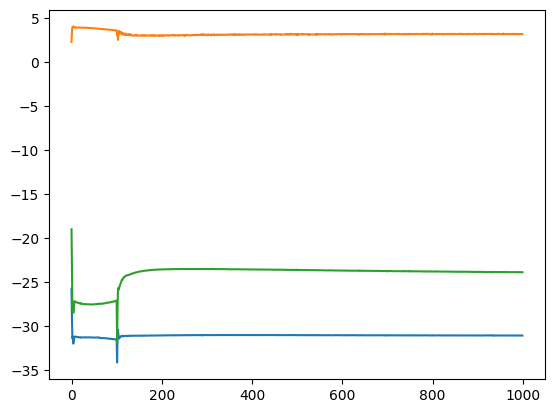

In [14]:
f = np.array(efs)
import matplotlib.pyplot as plt
plt.plot(f[:,0,...])